In [39]:
import os
import sys
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)

## Create Pipeline

In [58]:
from PynPoint2 import Pypeline

pipeline = Pypeline("/Users/markusbonse/Desktop/Workplace_wv",
                    "/Users/markusbonse/Desktop",
                    "/Users/markusbonse/Desktop/Results_ADI_wv")

In [71]:
from PynPoint2 import Pypeline

pipeline = Pypeline("/Users/markusbonse/Desktop/Workplace_no_wv",
                    "/Users/markusbonse/Desktop",
                    "/Users/markusbonse/Desktop/Results_ADI_no_wv")

## Create Data Port

In [80]:
from PynPoint2.core import InputPort

data_port = InputPort("09_star_arr_shifted_01",
                     pipeline.m_data_storage)

In [59]:
from PynPoint2.core import InputPort

data_port = InputPort("10_wavelet_denoised_soft_01",
                     pipeline.m_data_storage)

## Get Planet line

In [81]:
import numpy as np
pos = [66, 48] # speckle
#pos = [67, 60] # e

planet_line = data_port[:, pos[0], pos[1]]

## Plot Density

In [38]:
%matplotlib nbagg    
import numpy as np
from sklearn.grid_search import GridSearchCV

# estimate bandwidth
from sklearn.grid_search import GridSearchCV
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.2, 10.0, 20),
                    'rtol' : [4.0,]},
                    cv=5)
grid.fit(planet_line[:, None])

print grid.best_params_['bandwidth']

KeyboardInterrupt: 

## GMM

In [ ]:
from sklearn import mixture
import numpy as np

gmm = mixture.GaussianMixture(n_init=1,n_components=1, covariance_type='full').fit(np.reshape(planet_line, (-1, 1)))

gmm = mixture.BayesianGaussianMixture(n_components=4, 
                                      covariance_type='full',
                                      weight_concentration_prior=1e+5,
                                      weight_concentration_prior_type='dirichlet_process',
                                      mean_precision_prior=1e-2, covariance_prior=1e0 * np.eye(1),
                                      init_params="random", 
                                      max_iter=1000, 
                                      random_state=2).fit(np.reshape(planet_line, (-1, 1)))

print zip(gmm.means_, gmm.covariances_)
gaussians = zip(gmm.means_, gmm.covariances_, gmm.weights_ )

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/utils/graph.py:17: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .graph_shortest_path import graph_shortest_path
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/utils/graph.py:17: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  from .graph_shortest_path import graph_shortest_path
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/utils/sparsetools/__init__.py:3: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._traversal import connected_components
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/utils/sparsetools/__init__.py:3: RuntimeWarning: numpy.ufunc size changed, may indicate b

## Detect peaks

In [105]:
print np.sum(pdf[325:999])/10.
print np.sum(pdf[999:1913])/10.
print max(grid_space)
grid_space = np.linspace(-100, 100, 2000)
print (max(grid_space) - min(grid_space)) / len(grid_space)

0.386720952711
0.596594982469
100.0
0.1


## Detection Class

In [73]:
%matplotlib nbagg

import numpy
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from PynPoint2.util import detect_peaks

class PeakDetection(object):
    def __init__(self,
                 data_in,
                 grid_space=np.linspace(-100, 100, 2000)):
        self.m_data = data_in
        self.m_grid = grid_space
        self.m_resolution = (max(grid_space) - min(grid_space)) / len(grid_space)

        self.m_pdf = []
        self.m_peak_list = []

    @staticmethod
    def _kde_sklearn(x, x_grid, bandwidth=2.0, **kwargs):
        # Kernel Density Estimation with Scikit-learn
        kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
        kde_skl.fit(x[:, np.newaxis])
        # score_samples() returns the log-likelihood of the samples
        log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
        return np.exp(log_pdf)

    def calc_pdf(self,
                 bandwidth_in=4.0):
        self.m_pdf = self._kde_sklearn(self.m_data,
                                       self.m_grid,
                                       bandwidth=bandwidth_in)

    def plot_pdf(self):
        print "max mode " + str(self.m_grid[np.argsort(self.m_pdf)[-1]])
        print "mean " + str(np.mean(self.m_data))
        print "median " + str(np.median(self.m_data))

        mean_line = plt.axvline(np.mean(self.m_data), linestyle="--", color="cyan", label='Mean')
        median_line = plt.axvline(np.median(self.m_data), linestyle="--", color="magenta",
                                  label='Median')

        plt.plot(self.m_grid, self.m_pdf, color='blue', alpha=0.5, lw=3)
        if self.m_peak_list:
            for point in self.m_peak_list:
                if point[3] is "min":
                    point_color = "blue"
                else:
                    point_color = "red"
                plt.scatter(point[1], point[2], color=point_color, s=50)

        plt.title("KDE - PDF")
        plt.xlim(min(self.m_grid), max(self.m_grid))
        plt.legend(handles=[mean_line, median_line])
        plt.show()

    def detect_peaks(self):
        self._init_peaks()
        self._clean_peaks()

    def _init_peaks(self):
        distance_of_peaks = len(self.m_grid) / 100.

        # look for minima
        min_ind = detect_peaks(self.m_pdf,
                               show=False,
                               mpd=distance_of_peaks,
                               valley=True)

        # append last and first index
        min_ind = np.append(0, min_ind)
        min_ind = np.append(min_ind, len(self.m_grid) - 1)
        min_x = self.m_grid[min_ind]
        min_y = self.m_pdf[min_ind]
        self.m_peak_list = zip(min_ind, min_x, min_y, ["min"] * len(min_x))

        # look for maxima
        max_ind = detect_peaks(self.m_pdf,
                               show=False,
                               mph=np.max(self.m_pdf) / 10.,
                               mpd=distance_of_peaks,
                               valley=False)
        max_x = self.m_grid[max_ind]
        may_y = self.m_pdf[max_ind]
        self.m_peak_list += zip(max_ind, max_x, may_y, ["max"] * len(max_x))
        self.m_peak_list.sort(key=lambda tup: tup[0])

    def _clean_peaks(self):

        # search for minima with minima neighbors
        new_peaks = []

        i = 0
        while i < len(self.m_peak_list):
            n = 1.
            tmp_type = self.m_peak_list[i][3]
            tmp_mean_ind = self.m_peak_list[i][0]
            tmp_mean_x = self.m_peak_list[i][1]
            tmp_mean_y = self.m_peak_list[i][2]
            i += 1

            while i < len(self.m_peak_list) and tmp_type == self.m_peak_list[i][3]:
                tmp_mean_ind += self.m_peak_list[i][0]
                tmp_mean_x += self.m_peak_list[i][1]
                tmp_mean_y += self.m_peak_list[i][2]
                n += 1.
                i += 1

            new_peaks.append((int(tmp_mean_ind / n), tmp_mean_x / n, tmp_mean_y / n, tmp_type))

        self.m_peak_list = new_peaks
        

In [82]:
peak_detection = PeakDetection(planet_line)

In [83]:
peak_detection.calc_pdf(bandwidth_in=5.0)

In [84]:
peak_detection._init_peaks()

In [85]:
peak_detection._clean_peaks()

max mode -9.65482741371
mean 12.909549068
median 2.51305224075


<IPython.core.display.Javascript object>


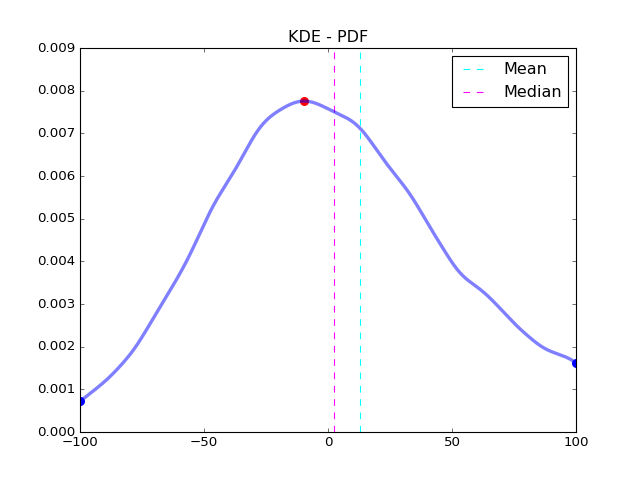

In [86]:
peak_detection.plot_pdf()